# Exercise 07: EM algorithm for Gaussian Mixture Model

In this exercise we will implement M-step and E-step of EM algorithm for Gaussian Mixture Model. We will test it and visualize on two example sample.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

Data preparation (sample 1)

(200, 2)
[[2.04936079 3.03741538]
 [1.77333326 2.88370357]
 [1.69114543 4.19838231]
 [2.56063402 3.80159296]
 [2.16216712 4.04973441]]


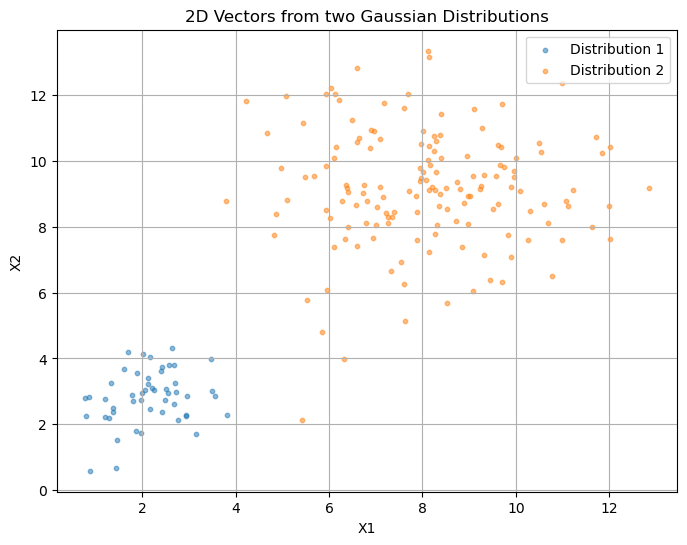

In [26]:
# Parameters for the Gaussian mixtures
mean_1 = [[2, 3], [8, 9]]
cov_1 = [ [[0.5, 0], [0, 0.5]], [[3, 0], [0, 3]] ]  


# Generate samples from each distribution
x_1_1 = np.random.multivariate_normal(mean_1[0], cov_1[0], 50)
x_1_2 = np.random.multivariate_normal(mean_1[1], cov_1[1], 150)

# Combine the samples
x_1 = np.vstack((x_1_1, x_1_2))
print(x_1.shape)
print(x_1[0:5, :])

# Plot the samples
plt.figure(figsize=(8, 6))
plt.scatter(x_1_1[:, 0], x_1_1[:, 1], alpha=0.5, label='Distribution 1', s=10)
plt.scatter(x_1_2[:, 0], x_1_2[:, 1], alpha=0.5, label='Distribution 2', s=10)
plt.title("2D Vectors from two Gaussian Distributions")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()

Data preparation (sample 2)

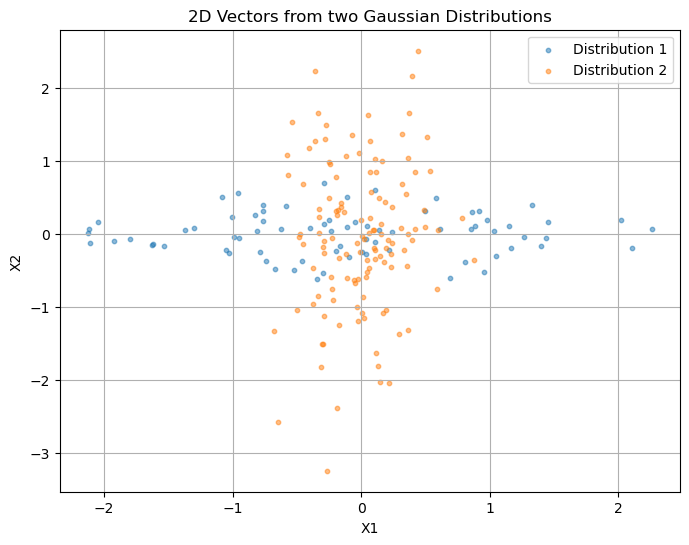

In [27]:
# Parameters for the Gaussian mixtures
mean_2 = [[0, 0], [0, 0]]
cov_2 = [
    [[1, 0], [0, 0.1]],  # Elongated along X-axis
    [[0.1, 0], [0, 1]],  # Elongated along Y-axis
] 


# Generate samples from each distribution
x_2_1 = np.random.multivariate_normal(mean_2[0], cov_2[0], 75)
x_2_2 = np.random.multivariate_normal(mean_2[1], cov_2[1], 125)

# Combine the samples
x_2 = np.vstack((x_2_1, x_2_2))

# Plot the samples
plt.figure(figsize=(8, 6))
plt.scatter(x_2_1[:, 0], x_2_1[:, 1], alpha=0.5, label='Distribution 1', s=10)
plt.scatter(x_2_2[:, 0], x_2_2[:, 1], alpha=0.5, label='Distribution 2', s=10)
plt.title("2D Vectors from two Gaussian Distributions")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()

Utility functions

In [ ]:

def multivariate_normal_pdf_array(x, mean, cov):
    """
    Calculate the multivariate normal PDF for an array of points.
    
    Parameters:
    - x: ndarray
        Array of points at which to evaluate the PDF (shape: (..., dim)).
    - mean: ndarray
        The mean of the multivariate normal distribution (1D array).
    - cov: ndarray
        The covariance matrix of the multivariate normal distribution (2D square array).
        
    Returns:
    - ndarray
        Array of the same shape as the input, containing the PDF values.
    """
    dim = mean.shape[0]

    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)

    norm = 1 / (((2 * np.pi) ** (dim/2)) * (det_cov ** (1/2)))
    diff = x - mean

    exp_term = (-0.5) * np.sum(diff @ inv_cov * diff, axis=1)
    return norm * np.exp(exp_term)



# Function to plot multiple ellipses for a single bivariate normal distribution
def plot_ellipses(ax, mean, cov, color, label, levels=[1, 2, 3]):
    """
    Add multiple ellipses corresponding to different levels of standard deviations.
    
    Parameters:
    - ax: Matplotlib axis to plot on.
    - mean: Mean of the distribution (center of the ellipse).
    - cov: Covariance matrix.
    - color: Color of the ellipse.
    - label: Label for the plot.
    - levels: List of standard deviation levels to plot.
    """
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    for level in levels:
        width, height = 2 * level * np.sqrt(eigenvalues)  # Scale by standard deviation level
        ellipse = Ellipse(mean, width, height, angle=angle, edgecolor=color, facecolor='none', lw=2, alpha=0.5
                                             )
        ax.add_patch(ellipse)



#scatter plot with cluster assignment
def scatter_cluster(x, w, all_means, all_covariances, threshold = 0.5):
    categories = np.argmax(w, axis=1)  # Shape: (N,)

    # Scatter plot with different colors for categories
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['red', 'blue']  # Extend if more clusters
    for cluster in range(w.shape[1]):  # Iterate over clusters
        cluster_points = x[categories == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.7,
                    label=f"Cluster {cluster + 1}", color=colors[cluster % len(colors)])

    # Add ellipses for covariance visualization
    for mean, cov, color in zip(all_means, all_covariances, colors):
        plot_ellipses(ax, mean, cov, color, f'Bivariate Normal (mean={mean})')

    plt.title("Scatterplot with Clusters")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
# test implementation using scipy stats
from scipy.stats import multivariate_normal
mean = np.array([1.0, 2.0])  
cov = np.array([[1.0, 0.5], [0.5, 2.0]])  
x_vector = np.array([[1.5, 2.5], [1.0, 2.0], [2.0, 3.0]])  

pdf_scipy = multivariate_normal(mean=mean, cov=cov).pdf(x_vector)
pdf_impl = multivariate_normal_pdf_array(x_vector, mean, cov)

In [30]:
print("PDF values from my implementation:", pdf_impl)
print("PDF values from scipy.stats:", pdf_scipy)

print("Results close?: ", np.allclose(pdf_impl, pdf_scipy, atol=1e-8))

PDF values from my implementation: [0.10429393 0.12030983 0.06794114]
PDF values from scipy.stats: [0.10429393 0.12030983 0.06794114]
Results close?:  True


Define E-step

Input: <br>
mean_it = [[1, 2], [0, 1]] # Shape (2, 2) <br>
cov_it = [ [[1, 0], [0, 1]], [[1, 0], [0, 0.5]] ] # Shape(2, 3) <br>
pi_it = [0.2,0.8] # Shape (1,) <br>
x_i # Shape (200, 2)

In [31]:
def e_step(x, mean, cov, pi):
    """
    Calculate the value of Q-function and matrix W of cluster membership probabilities (see page 360 in lecture)
    
    Parameters:
    - x: ndarray
        Array of points in sample.
    - mean: ndarray
        The mean of the multivariate normal distribution (1D array).
    - cov: ndarray
        The covariance matrix of the multivariate normal distribution (2D square array).
    - pi: ndarray
        The vector of mixing weights (see page 353 in lecture)
        
    Returns:
    - Q: float
        Value of Q-function
    - w: ndarray
        matrix W of cluster membership probabilities
    """
    N = x.shape[0]
    K = mean.shape[0]

    l_c = np.zeros((N, K))

    for k in range(K):
        l_c[:, k] = pi[k] * multivariate_normal_pdf_array(x, mean[k], cov[k]) # pi[0] * pdf(x, mean[0], cov[0]) all data points 
    
    # cluster membership prob
    W = l_c / np.sum(l_c, axis=1, keepdims=True) # sum over rows

    Q = np.sum(np.sum(np.log(W), axis=1)) # sum over k for each row(log cluster membership) then sum over all i

    return Q, W


In [32]:
# small test for the e-step generated using chatGPT
# Small dataset (N = 2 points, dim = 2)
x_test = np.array([[1.0, 2.0],
                   [3.0, 4.0]])  # Shape (2, 2)

# Parameters for two clusters (K = 2)
mean_test = np.array([[1.0, 2.0],  
                      [3.0, 4.0]]) 
cov_test = np.array([[[1.0, 0.0],  
                      [0.0, 1.0]],
                     [[1.0, 0.0],  
                      [0.0, 1.0]]])  
pi_test = np.array([0.5, 0.5])  # Equal mixing coefficient

In [33]:
Q_test, W_test = e_step(x_test, mean_test, cov_test, pi_test)

In [34]:
print("Responsibilities (W):")
print(W_test)

Responsibilities (W):
[[0.98201379 0.01798621]
 [0.01798621 0.98201379]]


Define M-step

In [35]:
def m_step(x, w, mean, cov):
    """
    Calculates the updated values of mean, covariance and pi in GMM (see page 362 in lecture)
    
    Parameters:
    - x: ndarray
        Array of points in sample.
    - w: ndarray
        matrix W of cluster membership probabilities
    - mean: ndarray
        The mean of the multivariate normal distribution (1D array).
    - cov: ndarray
        The covariance matrix of the multivariate normal distribution (2D square array).
        
    Returns:
    - mean_new: ndarray
        The updated mean of the multivariate normal distribution (1D array).
    - cov_new: ndarray
        The updated covariance matrix of the multivariate normal distribution (2D square array).
    - pi_new: ndarray
        The updated vector of mixing weights.
    """
    N, K = w.shape
    dim = x.shape[1]
    pi_new = np.sum(w, axis=0) / N

    mean_new = np.zeros((K, dim))
    for k in range(K):
        mean_new[k] = np.sum(w[:, k][:, np.newaxis] * x, axis=0) / np.sum(w[:, k])

    cov_new = np.zeros((K, dim, dim))
    for k in range(K):
        diff = x - mean_new[k]
        cov_new[k] = (w[:, k][:, np.newaxis] * diff).T @ diff / np.sum(w[:, k])
        cov_new[k] += 1e-6 * np.eye(dim)    


    return pi_new, mean_new, cov_new

Run EM algorithm for sample 1

Iteration   1: Q=-7424.628064806223, pi=[0.96497153 0.03502847], mean=[[6.77396404 7.77898145]
 [1.55239149 1.82174872]]


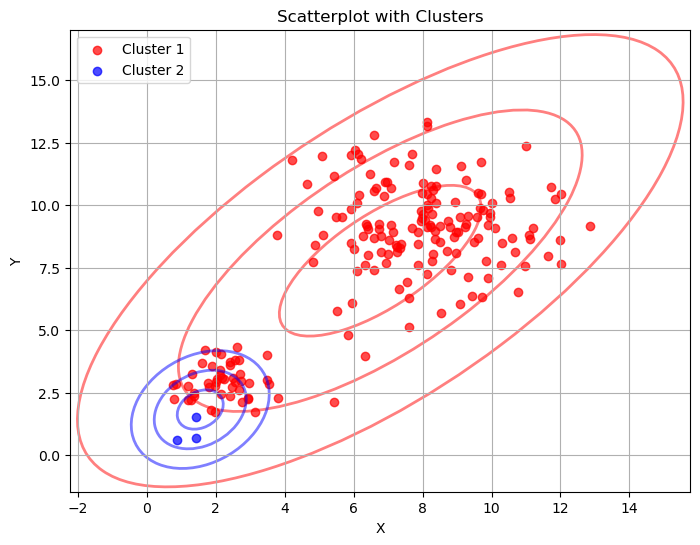

Iteration   2: Q=-11959.336633718953, pi=[0.92015615 0.07984385], mean=[[7.00959968 8.02256514]
 [1.76762612 2.35830366]]


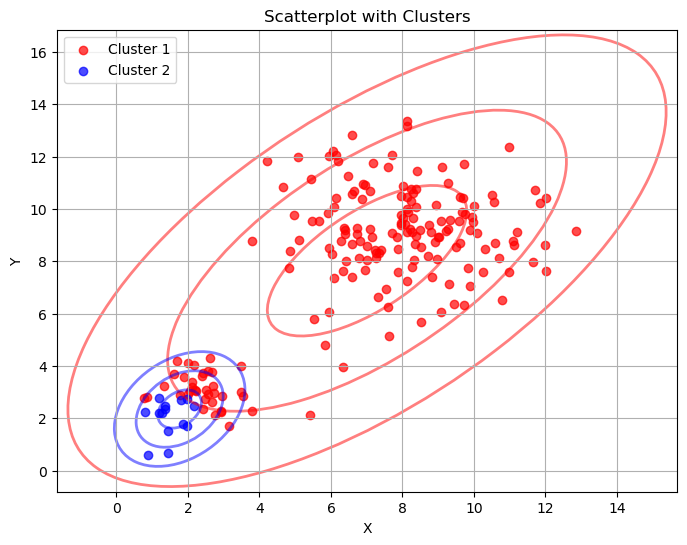

Iteration   3: Q=-12108.519638842357, pi=[0.84428215 0.15571785], mean=[[7.44886971 8.47472389]
 [1.9401281  2.66668567]]


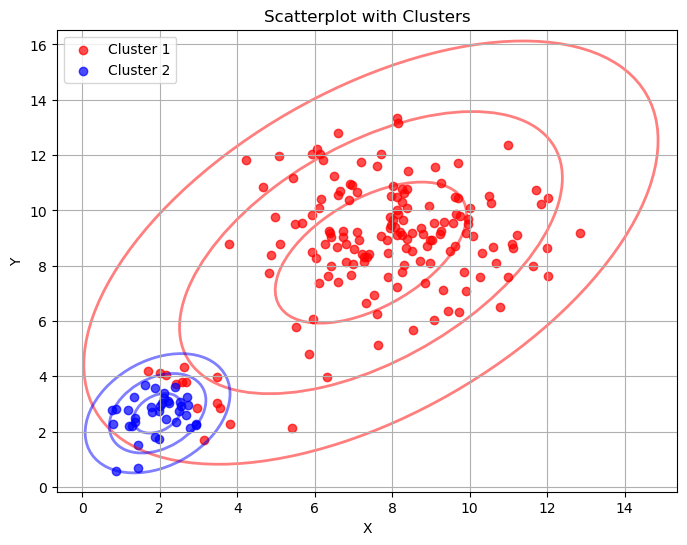

Iteration   4: Q=-11236.924038417666, pi=[0.78126184 0.21873816], mean=[[7.86232412 8.90835049]
 [2.05051777 2.79125671]]


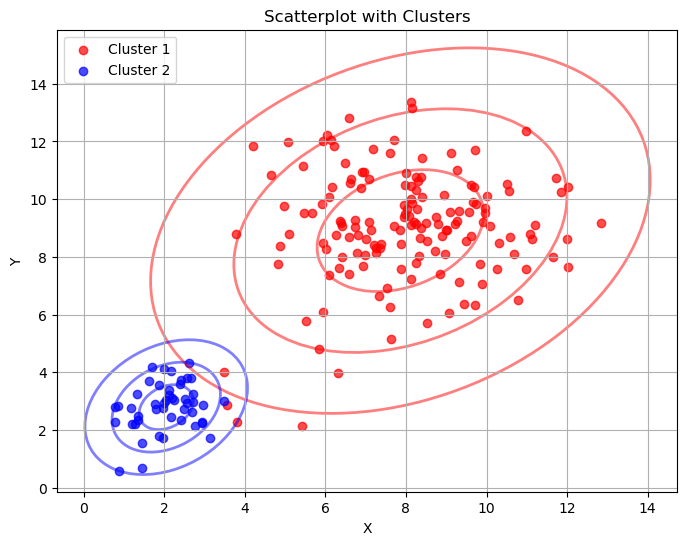

Iteration   5: Q=-9673.948564855316, pi=[0.75239327 0.24760673], mean=[[8.05710834 9.13325331]
 [2.13623531 2.82104757]]


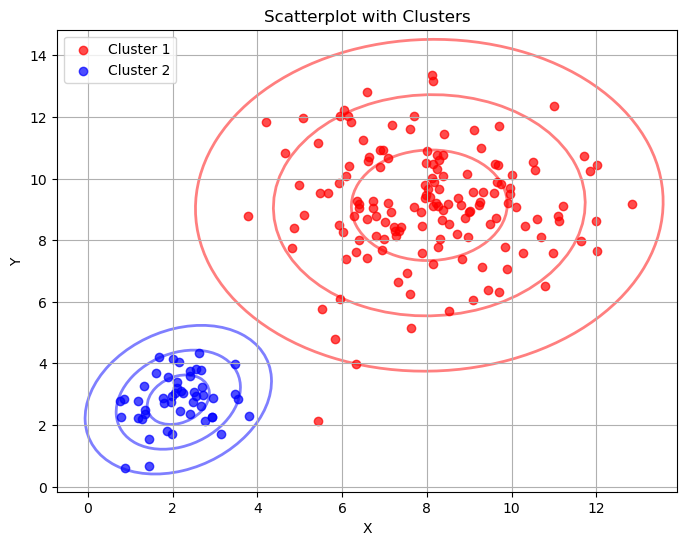

Iteration   6: Q=-8840.945717381766, pi=[0.74979852 0.25020148], mean=[[8.07325441 9.15405826]
 [2.14925229 2.82416127]]


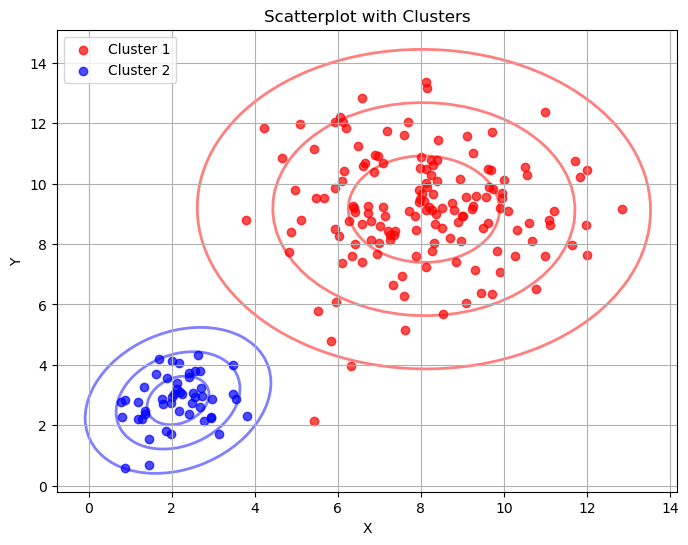

Iteration   7: Q=-8736.080292994324, pi=[0.74938334 0.25061666], mean=[[8.0747844  9.15790313]
 [2.15449128 2.82315085]]


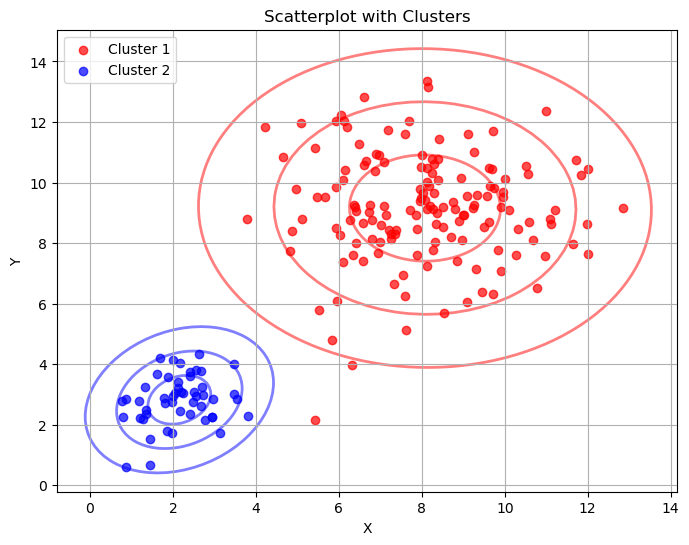

Iteration   8: Q=-8672.41584978958, pi=[0.74904447 0.25095553], mean=[[8.0759917  9.16107241]
 [2.15888207 2.82224521]]


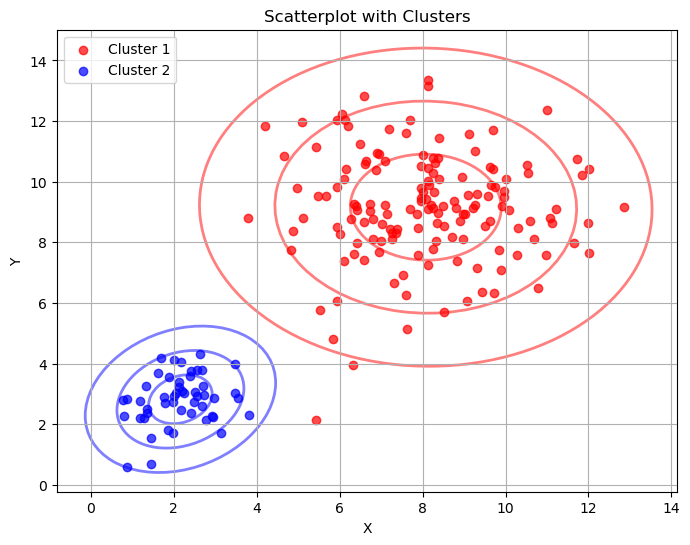

Iteration   9: Q=-8623.359548441122, pi=[0.74868766 0.25131234], mean=[[8.07726204 9.16441383]
 [2.16349872 2.82129066]]


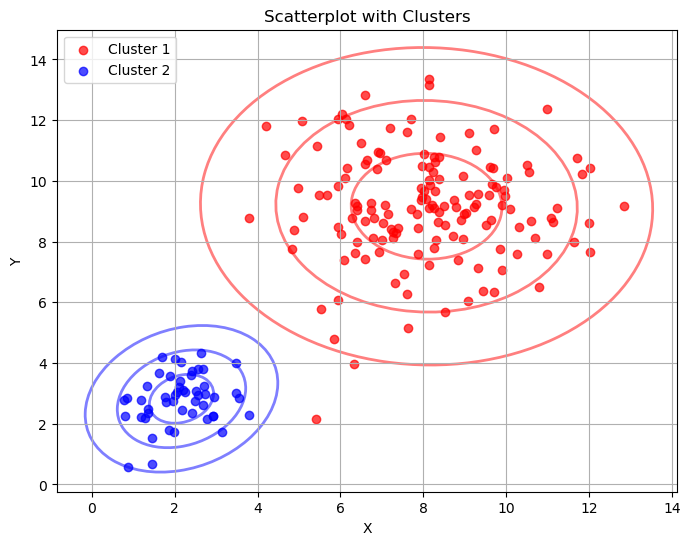

Iteration  10: Q=-8575.703390156505, pi=[0.74825555 0.25174445], mean=[[8.07880082 9.16846508]
 [2.16907563 2.82013676]]


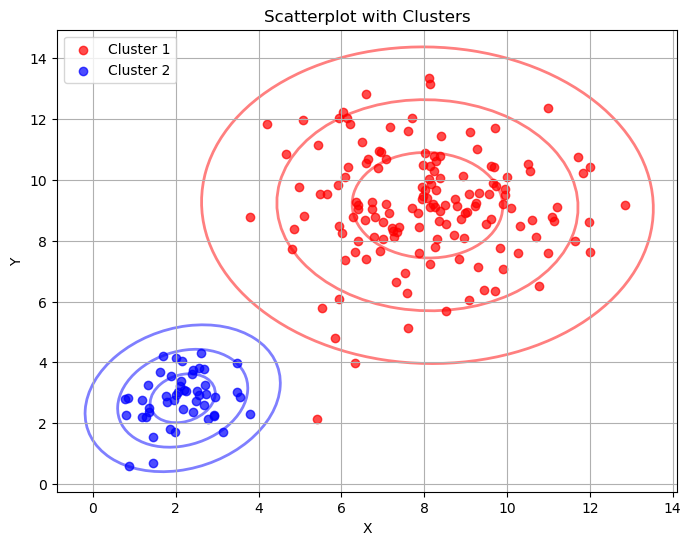

In [36]:
#initialization (you can play with initial parameters)
mean_it = np.array([[1, 2], [0, 1]])
cov_it = np.array([ [[1, 0], [0, 1]], [[1, 0], [0, 0.5]] ])
pi_it = np.array([0.2,0.8])

for it in range(10):
    Q, w = e_step(x_1, mean_it, cov_it, pi_it)
    pi_it,  mean_it, cov_it = m_step(x_1, w, mean_it, cov_it)
    print(f"Iteration {it+1:3d}: Q={Q}, pi={pi_it}, mean={mean_it}")
    scatter_cluster(x_1, w, mean_it, cov_it)

Run EM algorithm for sample 2

Iteration   1: Q=-623.6165737215842, pi=[0.07093076 0.92906924], mean=[[ 0.25974556 -0.18589356]
 [-0.07812633 -0.00779563]]


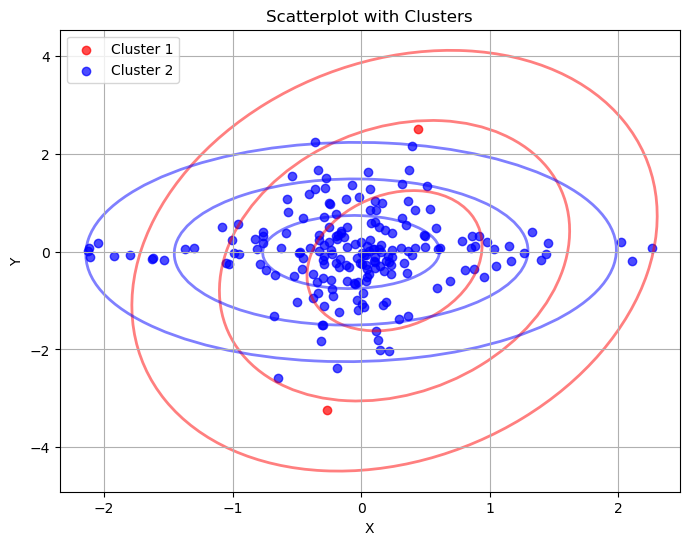

Iteration   2: Q=-626.3903348407848, pi=[0.07658504 0.92341496], mean=[[ 0.12241657 -0.38825108]
 [-0.06880558  0.01007778]]


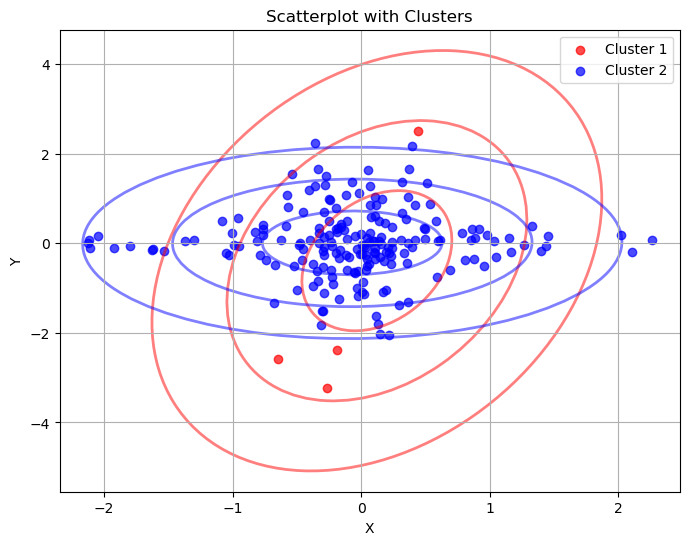

Iteration   3: Q=-639.333380299455, pi=[0.08771392 0.91228608], mean=[[ 0.0230166  -0.46998822]
 [-0.06158123  0.02279577]]


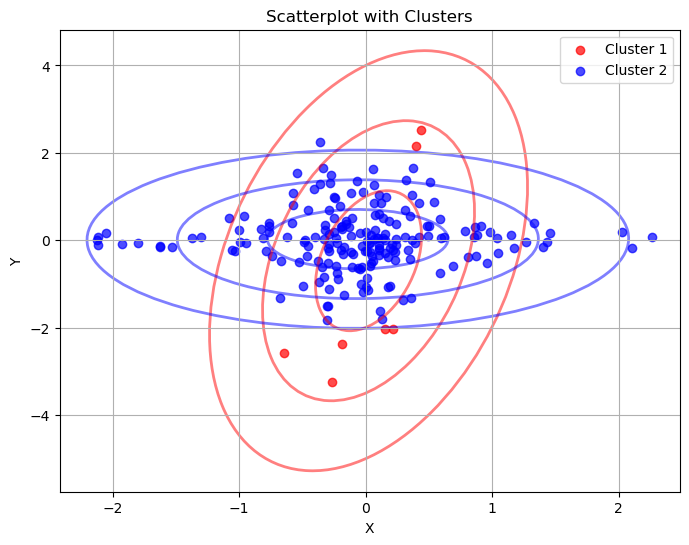

Iteration   4: Q=-716.6158641533943, pi=[0.11172937 0.88827063], mean=[[-0.01229615 -0.44074992]
 [-0.05942669  0.03244108]]


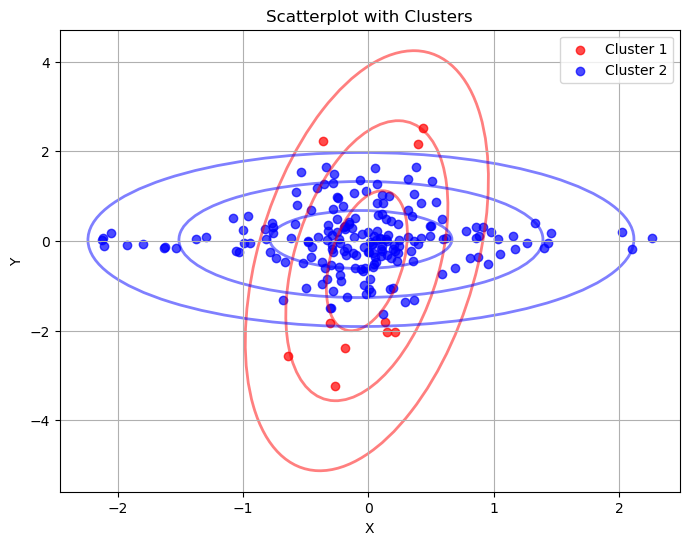

Iteration   5: Q=-855.1175359836442, pi=[0.1473989 0.8526011], mean=[[-0.0196051  -0.37305258]
 [-0.06013487  0.04053395]]


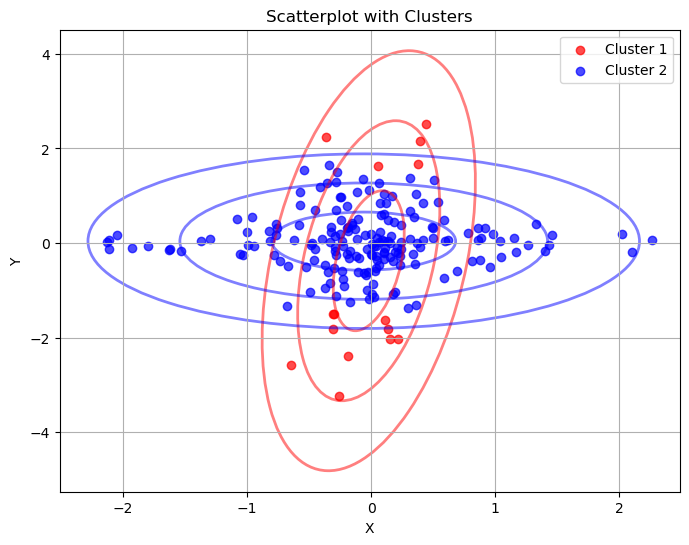

Iteration   6: Q=-932.6396135292994, pi=[0.19062543 0.80937457], mean=[[-0.02252206 -0.30270778]
 [-0.06161245  0.04605476]]


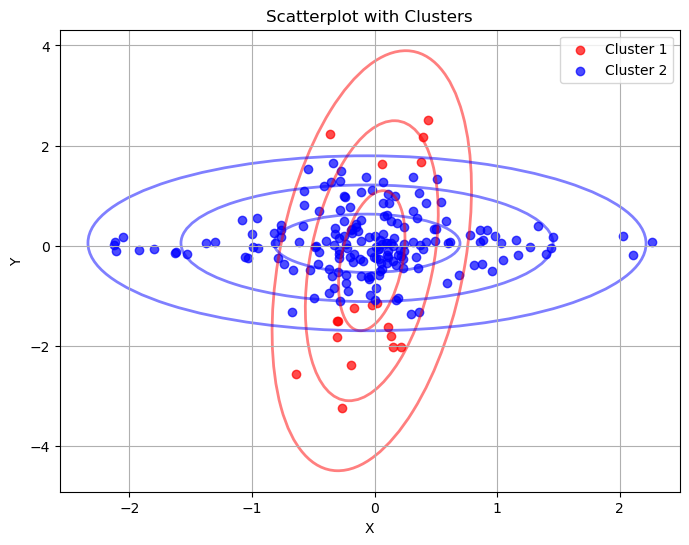

Iteration   7: Q=-948.2061146399551, pi=[0.2389334 0.7610666], mean=[[-0.02693705 -0.23772481]
 [-0.0627076   0.04779102]]


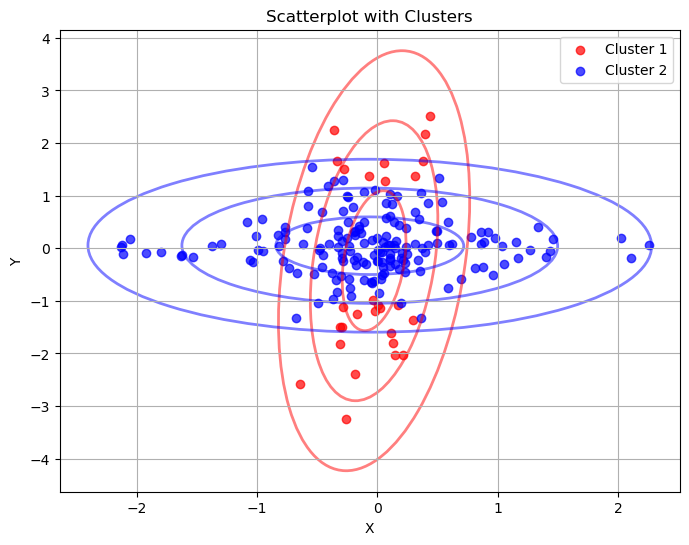

Iteration   8: Q=-938.225612582472, pi=[0.29032551 0.70967449], mean=[[-0.03334582 -0.18114842]
 [-0.06267618  0.04532185]]


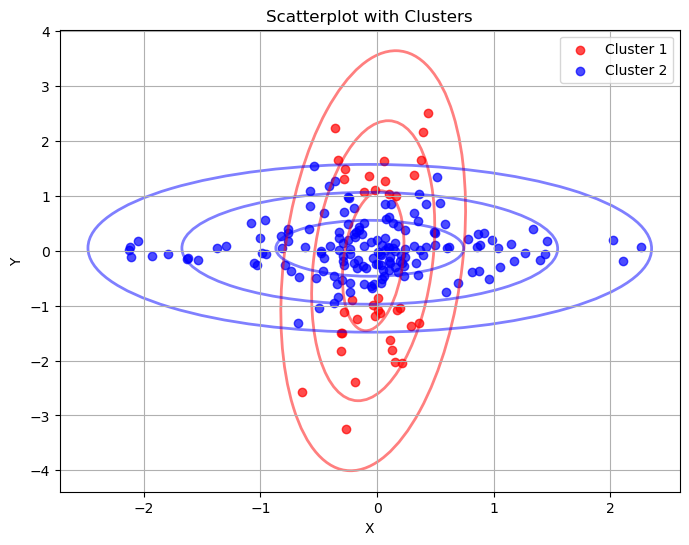

Iteration   9: Q=-924.6725985843606, pi=[0.3426659 0.6573341], mean=[[-0.04084915 -0.13408108]
 [-0.06110015  0.03881856]]


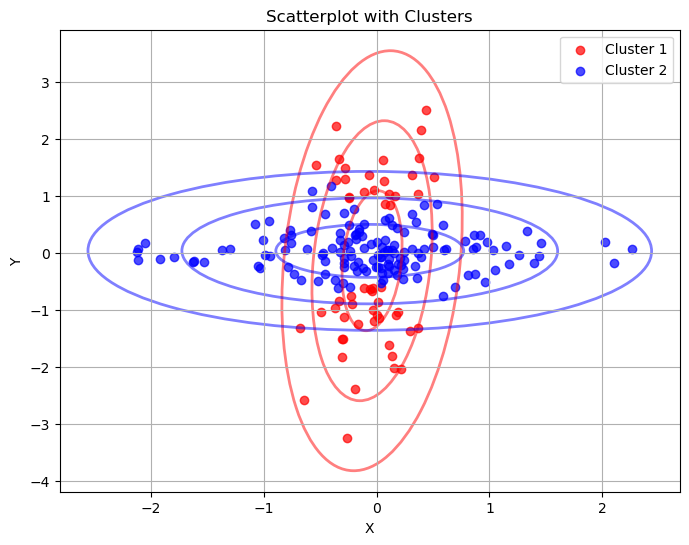

Iteration  10: Q=-922.409490081067, pi=[0.39326414 0.60673586], mean=[[-0.04773476 -0.09750495]
 [-0.05832597  0.02953007]]


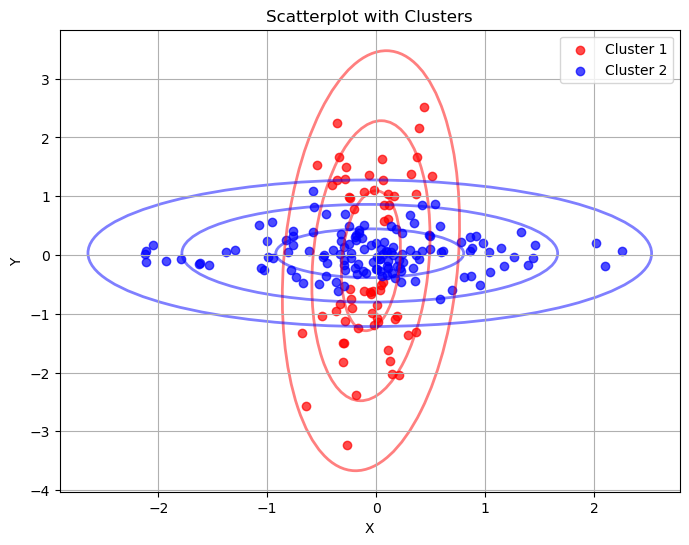

In [37]:
#initialization (you can play with initial parameters)
mean_it = np.array([[1, 2], [0, 1]])
cov_it = np.array([ [[1, 0], [0, 1]], [[1, 0], [0, 0.5]] ] )
pi_it = np.array([0.2,0.8])

for it in range(10):
    Q, w = e_step(x_2, mean_it, cov_it, pi_it)
    pi_it,  mean_it, cov_it = m_step(x_2, w, mean_it, cov_it)
    print(f"Iteration {it+1:3d}: Q={Q}, pi={pi_it}, mean={mean_it}")
    scatter_cluster(x_2, w, mean_it, cov_it)